In [1]:
import polars as pl
from sklearn.model_selection import KFold
import numpy as np

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    for col in df_train.columns:
        df_train, df_test = scale_column(df_train, df_test, col)
    return df_train, df_test

def scale_column(df_train, df_test, col_name):
    max = df_train.get_column(col_name).max()
    min = df_train.get_column(col_name).min()
    df_train = df_train.with_columns((pl.col(col_name) - min) / (max - min))
    df_test = df_test.with_columns((pl.col(col_name) - min) / (max - min))
    return df_train, df_test

f_name = 'crime.csv'
df = pl.read_csv(f_name, has_header=True, sep=',') # comma separated data
df_train, df_test = fetch_data(df, 0)
# X, y = df.drop('CRIM'), df.get_column('CRIM')
# X = X.with_columns(pl.col('RM').fill_null(pl.median('RM')))
# X = X.with_columns(pl.lit(1.0).alias("CONSTANT"))
# print(X.head())

def get_x_y(df):
    X, y = df.drop('CRIM'), df.get_column('CRIM')
    X = X.with_columns(pl.col('RM').fill_null(pl.median('RM')))
    X = X.with_columns(pl.lit(1.0).alias("CONSTANT"))
    return X.to_numpy(), y.to_numpy()
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)
# X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
# y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
y_train[0]

0.0

In [2]:
y_train.min()

SeriesView(0.)

In [3]:
# l = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] # todo: choose lambda values
l = np.logspace(-5, 5)

def linear_regression(X, y, lambdas):
    weights = []
    phi = X
    I = np.eye(X.shape[1])
    for l in lambdas:
        inside_part = np.linalg.inv(l*I + np.matmul(phi.T, phi))
        w = np.matmul(np.matmul(inside_part, phi.T), y)
        weights.append(w)
    return weights

weights = linear_regression(X_train, y_train, l)

In [4]:
def score(X, y, w):
    preds = []
    for x in X:
        preds.append(np.dot(x, w))
    preds = np.array(preds)
    u = ((y - preds)**2).sum()
    v = ((y - y.mean())**2).sum()
    r2 = 1 - (u/v)
    return r2

def run_experiment(df, use_split, lambdas):
    df_train, df_test = fetch_data(df, use_split)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    all_weights = linear_regression(X_train, y_train, lambdas)
    scores = [score(X_test, y_test, w).item() for w in all_weights]
    return np.array(scores)

def sk_bench(df, use_split):
    from sklearn import linear_model
    df_train, df_test = fetch_data(df, use_split)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    # solver = "sag"
    solver = "cholesky"
    reg = linear_model.Ridge(alpha = 0.5, solver=solver)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

perf = [run_experiment(df, x, l) for x in range(5)]
out = np.stack(perf)
out.shape

(5, 50)

In [5]:
print(f"Best: {out.mean(axis=0).argmax()}")
print(f"Best Score: {out.mean(axis=0).max()}")
# 16
# 0.48078

Best: 25
Best Score: 0.4862718815487477


In [6]:
l[25]

1.2648552168552958

In [7]:
import seaborn
COLORS = seaborn.color_palette()
# COLORS = [(x[0] / 255.0, x[1] / 255.0, x[2] / 255.0, x[3]) for x in COLORS]
# COLORS = ["#5585a8", "#be614e"]

Text(0.5, 1.0, 'Weight Decay')

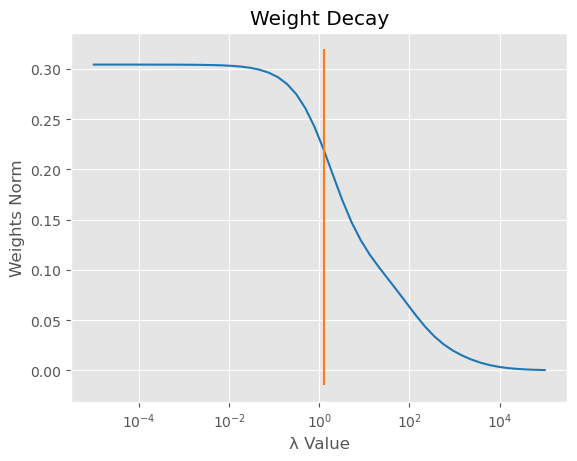

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
f, ax = plt.subplots()
ax.plot(l, [np.linalg.norm(x) for x in weights], color=COLORS[0])
ax.vlines(l[out.mean(axis=0).argmax()], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color=COLORS[1])
ax.set_xscale("log")
ax.set_ylabel("Weights Norm")
ax.set_xlabel("λ Value")
ax.set_title("Weight Decay")

<AxesSubplot: title={'center': '5-Fold Cross Validation R^2 Score'}, xlabel='Trial', ylabel='R^2'>

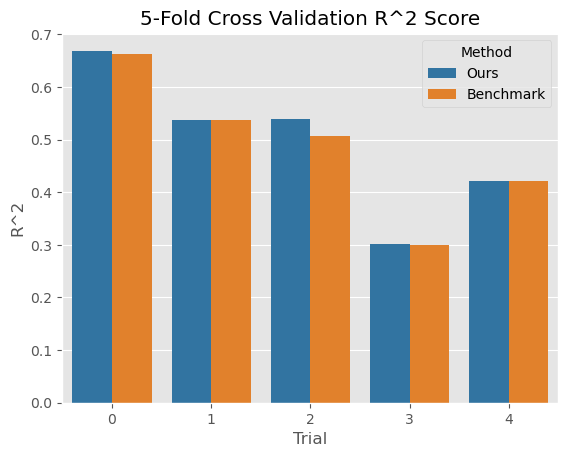

In [9]:
import seaborn
import pandas as pd 
plt.style.use('ggplot')
f, ax = plt.subplots()
our_method = out.max(axis=1).tolist()
benchmark = [sk_bench(df, x) for x in range(5)]
method = ["Ours" for _ in range(5)] + ["Benchmark" for _ in range(5)]
plot_df = pd.DataFrame.from_dict({"R^2": our_method + benchmark, "Method": method, "Trial": list(range(5)) + list(range(5))})
# ax.set_ylim(0.7, 0.88)
ax.set_title("5-Fold Cross Validation R^2 Score")
seaborn.barplot(data=plot_df, x="Trial", y="R^2", hue="Method", ax=ax, palette=COLORS)

In [10]:
def score(X, y, w):
    preds = []
    for x in X:
        preds.append(np.dot(x, w))
    preds = np.array(preds)
    u = ((y - preds)**2).sum()
    v = ((y - y.mean())**2).sum()
    r2 = 1 - (u/v)
    return r2

scores = [score(X_test, y_test, w) for w in weights]

In [11]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha = 0.5)
reg.fit(X_train, y_train)

print(reg.score(X_test, y_test))
print('coef', reg.coef_)
print('intercept', reg.intercept_)

print(y.mean())
print(y.std())

0.6620215262328881
coef [ 0.0476652  -0.01908966 -0.01271294 -0.0468053   0.00766503  0.00746123
 -0.10435697  0.14716651 -0.01165505 -0.02254665 -0.04176839  0.09674795
 -0.11246046  0.        ]
intercept 0.09488734237867957


NameError: name 'y' is not defined